# Hypothesis testing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from itertools import product
#from nltk.metrics import scores
from pathlib import Path
from scipy.stats import permutation_test

import evaluationaux  as ev

%matplotlib inline

In [2]:
PATH = '/project/brie/scripts_scorekeeping/'
PATH_OUTPUTS = Path(PATH, 'main_task', 'outputs')
PROPS = Path(PATH, 'main_task', 'data', 'propositions')

In [3]:
BOTS =  ('a', 'q')
CONTROL_TASKS =  ('none', 'rand-reps', 'null-reps')
TASKS =  ('TFxPS', 'TF', 'PS', 'PxTSFS')
BOT_VERSIONS =  ('RL-DIV', 'SL', 'ICCV-RL')

In [4]:
with open(Path(PROPS, 'propositions_test.json'), 'r') as f:
    props_test = json.load(f)['dialogues']

# Results on test set

Get all results on test set:

In [5]:
split = 'test'

In [6]:
test_results = {}
test_accs = {}
missing = 0  # a few combinations have no experiment (e.g. TF task for the questioner)
epoch = 0  # for the test set, the only inference step is saved as 0

# embs='pmbv2', model='Deeper' as default on ev.get_data

for (bot, control_task, task, version) in product(BOTS, CONTROL_TASKS, TASKS, BOT_VERSIONS):
    try:
        _, outputs = ev.get_data(bot, task, control_task, epoch=epoch, path=PATH_OUTPUTS,
                                            split=split, bot_version=version)
        test_results[(bot, task, control_task, version)] = outputs
        test_accs[(bot, task, control_task, version)] = 100*np.mean([pred==gold for (pred, gold) in outputs.values()]) 
    except FileNotFoundError:
        test_results[(bot, task, control_task, version)] = {}
        test_accs[(bot, task, control_task, version)] = '-'
        assert bot == 'q' and task in ('TFxPS', 'TF')
        missing += 1

assert len(test_results) ==  72                    
assert len(test_accs) == 72
assert missing == 18

Table with overall acc for RL-DIV: 

In [7]:
df = pd.DataFrame(columns=TASKS)

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs[bot, t, control_task, 'RL-DIV'] for t in TASKS]
df = df.style.set_caption("Performance on test set, all turns, RL_DIV")        
df

,TFxPS,TF,PS,PxTSFS
"a, none",62.047023,71.026139,80.943089,73.064895
"a, rand-reps",35.108714,52.482842,60.353026,47.957719
"a, null-reps",37.660124,50.612620,60.256262,50.643379
"q, none",-,-,82.027030,74.350052
"q, rand-reps",-,-,59.003787,48.801033
"q, null-reps",-,-,60.182889,50.640816


Full table:

In [8]:
elements = list(product(TASKS, BOT_VERSIONS))
df = pd.DataFrame(columns=[elem for elem in elements])

for bot, control_task in product(BOTS, CONTROL_TASKS):
    df.loc[f'{bot}, {control_task}'] = [test_accs[bot, t, control_task, v] for t, v in elements]      
df = df.style.set_caption("Performance on test set, all turns")
df

,"('TFxPS', 'RL-DIV')","('TFxPS', 'SL')","('TFxPS', 'ICCV-RL')","('TF', 'RL-DIV')","('TF', 'SL')","('TF', 'ICCV-RL')","('PS', 'RL-DIV')","('PS', 'SL')","('PS', 'ICCV-RL')","('PxTSFS', 'RL-DIV')","('PxTSFS', 'SL')","('PxTSFS', 'ICCV-RL')"
"a, none",62.047023,62.330264,61.786852,71.026139,70.925531,70.799931,80.943089,81.242030,80.791857,73.064895,73.368642,73.472775
"a, rand-reps",35.108714,35.566578,35.126657,52.482842,51.822161,53.178448,60.353026,60.659977,60.461644,47.957719,48.655247,48.625770
"a, null-reps",37.660124,37.529718,37.716836,50.612620,50.607494,50.613581,60.256262,60.246330,60.218454,50.643379,50.861577,50.620630
"q, none",-,-,-,-,-,-,82.027030,83.150701,83.060346,74.350052,73.905326,74.422785
"q, rand-reps",-,-,-,-,-,-,59.003787,59.750338,60.062736,48.801033,48.325227,48.496325
"q, null-reps",-,-,-,-,-,-,60.182889,60.134828,60.153091,50.640816,50.564239,50.537645


### Sanity check

In [9]:
dialogues_min_5turns = 0
total_datapoints_turn5 = 0
with open(Path(PATH, 'main_task', 'data', 'visdial_1.0_test_dialogueLens.txt'), 'r') as file:
    lines = file.readlines()
    for line in lines:
        idx, dialogue_len = line.strip('\n').split('\t')
        if int(dialogue_len) >= 6:
            n_props = len(props_test[idx])
            dialogues_min_5turns += 1
            total_datapoints_turn5 += n_props
print(dialogues_min_5turns)
print(total_datapoints_turn5)

4000
32360


We double check that all datapoints indexes correspond to the same information across experiments:

In [10]:
model = 'Deeper'
embs = 'pmbv2'

for task in TASKS:
    identifiers = []
    for bot, control_task, version in product(BOTS, CONTROL_TASKS, BOT_VERSIONS):
        if bot == 'q' and 'TF' in task:
            continue
        name = f'{bot}Bot_{version}_task-{task}_control-{control_task}_{model}_{embs}'
        with open(Path(PATH_OUTPUTS, name, 'identifiers_test'), 'r') as file:
            identifiers.append(file.read())
    if 'TF' in task:
        assert len(identifiers) == 9
    else:
        assert len(identifiers) == 18
    assert len(set(identifiers)) == 1 # check that all files are the same, i.e. indexes and datapoints match

We load one of the test data identifiers, all files should be the same except for the labels:

In [11]:
name = f'aBot_RL-DIV_task-TFxPS_control-none_Deeper_pmbv2'
with open(Path(PATH_OUTPUTS, name, 'identifiers_test'), 'r') as file:
    test_dataset = json.load(file) 

## Hypothesis testing for control tasks (turn=5)

Select parameters according to Scipy's [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html#scipy.stats.permutation_test):

In [12]:
def acc_diff(a, b):
    return np.mean(a)- np.mean(b)

def abs_acc_diff(a, b):
    return abs(np.mean(a)- np.mean(b))

In [13]:
permutation_type = 'samples'
alternative = 'greater'
n_samples = 1000
seed = 123
statistic = abs_acc_diff
alpha = 0.01

TURN = 5

Test statistic for the approximate randomization test is the different between accuracies:

In [14]:
p_values = {}
stats_distributions = {}
p_values_twosided = {}

for (bot, task, version) in product(BOTS, TASKS, BOT_VERSIONS):
    print(f'Bot: {bot}, Task: {task}, Version:{version}')
    if test_results[(bot, task, 'none', version)]:
        # get all indexes of datapoints at turn 5
        d_points = [int(k) for k, v in test_dataset.items() if v[-2] == TURN]
        assert len(d_points) == total_datapoints_turn5
        
        guesses = test_results[(bot, task, 'none', version)]
        rand_guesses = test_results[(bot, task, 'rand-reps', version)]
        null_guesses = test_results[(bot, task, 'null-reps', version)]

        guesses_turn_5 = np.array([1 if guesses[k][0] == guesses[k][1] else 0 for k in d_points])
        rand_guesses_turn_5 = np.array([1 if rand_guesses[k][0] == rand_guesses[k][1] else 0 for k in d_points])
        null_guesses_turn_5 = np.array([1 if null_guesses[k][0] == null_guesses[k][1] else 0 for k in d_points])

        assert len(guesses_turn_5) == total_datapoints_turn5
        assert len(rand_guesses_turn_5) == total_datapoints_turn5
        assert len(null_guesses_turn_5) == total_datapoints_turn5
        
        # Test main vs random dialogue representations
        test_outputs = permutation_test((guesses_turn_5, rand_guesses_turn_5), statistic=statistic, 
                                         permutation_type=permutation_type, n_resamples=n_samples,
                                         alternative=alternative, random_state=seed)
        p_values[(bot, task, version, 'main vs rand')] = test_outputs.pvalue
        stats_distributions[(bot, task, version, 'main vs rand')] = (test_outputs.statistic, 
                                                                     test_outputs.null_distribution)
        print(f'  Main vs. Random: {test_outputs.statistic} (p-value={test_outputs.pvalue})')
        
        # Test main vs null dialogue representations
        test_outputs = permutation_test((guesses_turn_5, null_guesses_turn_5), statistic=statistic, 
                                         permutation_type=permutation_type, n_resamples=n_samples,
                                         alternative=alternative, random_state=seed)
        p_values[(bot, task, version, 'main vs null')] = test_outputs.pvalue
        stats_distributions[(bot, task, version, 'main vs null')] = (test_outputs.statistic, 
                                                                     test_outputs.null_distribution)
        print(f'  Main vs. Null: {test_outputs.statistic} (p-value={test_outputs.pvalue})')

    else:
        p_values[(bot, task, version, 'main vs rand')] = 'NA'
        p_values[(bot, task, version, 'main vs null')] = 'NA'
        print('  NA')
                    
assert len(p_values) == 48

Bot: a, Task: TFxPS, Version:RL-DIV


/home/users/blasota/anaconda3/envs/scipy/lib/python3.9/site-packages/scipy/stats/_hypotests.py:1587: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


  Main vs. Random: 0.2654820766378245 (p-value=0.000999000999000999)
  Main vs. Null: 0.24375772558714465 (p-value=0.000999000999000999)
Bot: a, Task: TFxPS, Version:SL
  Main vs. Random: 0.24845488257107534 (p-value=0.000999000999000999)
  Main vs. Null: 0.251761433868974 (p-value=0.000999000999000999)
Bot: a, Task: TFxPS, Version:ICCV-RL
  Main vs. Random: 0.24712608158220023 (p-value=0.000999000999000999)
  Main vs. Null: 0.23896786155747834 (p-value=0.000999000999000999)
Bot: a, Task: TF, Version:RL-DIV
  Main vs. Random: 0.20794190358467235 (p-value=0.000999000999000999)
  Main vs. Null: 0.22394932014833124 (p-value=0.000999000999000999)
Bot: a, Task: TF, Version:SL
  Main vs. Random: 0.20491347342398025 (p-value=0.000999000999000999)
  Main vs. Null: 0.2185105067985167 (p-value=0.000999000999000999)
Bot: a, Task: TF, Version:ICCV-RL
  Main vs. Random: 0.19236711990111255 (p-value=0.000999000999000999)
  Main vs. Null: 0.21736711990111246 (p-value=0.000999000999000999)
Bot: a, Tas

We also check $p*2$ which would be the p-value for the two-sided case.

In [15]:
flag = 0
flag_double = 0
for test, p in p_values.items():
    if p != 'NA':
        if p > alpha:
            flag = 1
            print('p > alpha on:', test)
        if p*2 > alpha:
            flag_double = 1
            print('p*2 > alpha on:', test)
if not flag:
    print('All differences are thus statistically significant.') 

All differences are thus statistically significant.


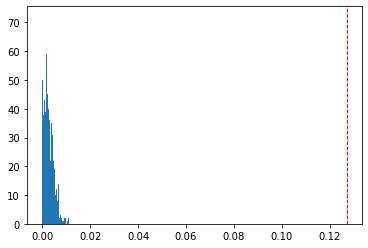

In [16]:
s, dist = stats_distributions[('a', 'PS', 'RL-DIV', 'main vs rand')]
plt.hist(dist, bins=50)
plt.axvline(s, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [17]:
0.000999000999000999*2

0.001998001998001998

## Hypothesis testing for questioner vs. answerer (turn=5)
 
Now we check the difference between a and q:

In [18]:
p_values_qa = {}
stats_distributions_qa = {}

for task, version in product(('PS', 'PxTSFS'), BOT_VERSIONS):
    print(f'Task: {task}, Version:{version}')
    # select only datapoints at turn 5
    d_points = [int(k) for k,v in test_dataset.items() if v[-2] == TURN]
    assert len(d_points) == total_datapoints_turn5

    guesses_a = test_results[('a', task, 'none', version)]
    guesses_q = test_results[('q', task, 'none', version)]

    guesses_a_turn_5 = np.array([1 if guesses_a[k][0] == guesses_a[k][1] else 0 for k in d_points])
    guesses_q_turn_5 = np.array([1 if guesses_q[k][0] == guesses_q[k][1] else 0 for k in d_points])

    assert len(guesses_a_turn_5) == total_datapoints_turn5
    assert len(guesses_q_turn_5) == total_datapoints_turn5

    test_outputs = permutation_test((guesses_a_turn_5, guesses_q_turn_5), statistic=statistic, 
                                    permutation_type=permutation_type, n_resamples=n_samples,
                                    alternative=alternative, random_state=seed)
    p_values_qa[(task, version, 'a vs q')] = test_outputs.pvalue
    stats_distributions_qa[(task, version, 'a vs q')] = (test_outputs.statistic, 
                                                              test_outputs.null_distribution)
    print(f'  A vs. Q: {test_outputs.statistic} (p-value={test_outputs.pvalue})')

assert len(p_values_qa) == 6

Task: PS, Version:RL-DIV
  A vs. Q: 0.010692212608158225 (p-value=0.000999000999000999)
Task: PS, Version:SL
  A vs. Q: 0.01999381953028434 (p-value=0.000999000999000999)
Task: PS, Version:ICCV-RL
  A vs. Q: 0.020797280593325085 (p-value=0.000999000999000999)
Task: PxTSFS, Version:RL-DIV
  A vs. Q: 0.012948084054388187 (p-value=0.000999000999000999)
Task: PxTSFS, Version:SL
  A vs. Q: 0.0015451174289246028 (p-value=0.6223776223776224)
Task: PxTSFS, Version:ICCV-RL
  A vs. Q: 0.0055006180469715504 (p-value=0.08091908091908091)


In [19]:
flag = 0
flag_double = 0
for test, p in p_values_qa.items():
    if p != 'NA':
        if p > alpha:
            flag = 1
            print('p > alpha on:', test)
        if p*2 > alpha:
            flag_double = 1
            print('p*2 > alpha on:', test)
if not flag:
    print('All differences are thus statistically significant.')  

p > alpha on: ('PxTSFS', 'SL', 'a vs q')
p*2 > alpha on: ('PxTSFS', 'SL', 'a vs q')
p > alpha on: ('PxTSFS', 'ICCV-RL', 'a vs q')
p*2 > alpha on: ('PxTSFS', 'ICCV-RL', 'a vs q')


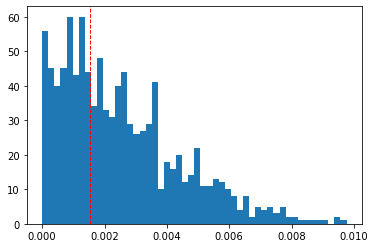

In [20]:
s, dist = stats_distributions_qa[('PxTSFS', 'SL', 'a vs q')]
plt.hist(dist, bins=50)
plt.axvline(s, color='r', linestyle='dashed', linewidth=1)
plt.show()